# Pre-Processing and Training Data Development for Capstone 2 - Solar Plants Data

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from datetime import datetime as dt
import matplotlib.dates as mdates
import calplot

from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

### Import Data Files

In [2]:
# File path locations

solarplants_path = '../Data/solar_plants.csv'
plant1_path = '../Data/plant1.csv'
plant2_path = '../Data/plant2.csv'

In [3]:
# Read file paths into dataframes

sp_df = pd.read_csv(solarplants_path)
p1_df = pd.read_csv(plant1_path)
p2_df = pd.read_csv(plant2_path)

### Apply Adjustments from EDA

In [4]:
# Adjust DC_POWER column for Plant 2 in sp_df and p2_df

sp_df.loc[sp_df.PLANT == 'plant_2', 'DC_POWER'] = sp_df.loc[sp_df.PLANT == 'plant_2','DC_POWER']*10

p2_df['DC_POWER_s'] = p2_df['DC_POWER'] * 10

In [5]:
# Create DATE and TIME columns

sp_df['TIME'] = pd.to_datetime(sp_df['DATE_TIME']).dt.time
sp_df['DATE'] = pd.to_datetime(sp_df['DATE_TIME']).dt.date

p1_df['TIME'] = pd.to_datetime(p1_df['DATE_TIME']).dt.time
p1_df['DATE'] = pd.to_datetime(p1_df['DATE_TIME']).dt.date
p2_df['TIME'] = pd.to_datetime(p2_df['DATE_TIME']).dt.time
p2_df['DATE'] = pd.to_datetime(p2_df['DATE_TIME']).dt.date

In [6]:
sp_df.sample(10)

,DATE_TIME,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT,TIME,DATE
66736,2020-06-17 00:15:00,4135001,ZnxXDlPa8U1GXgE,0.000000,0.000000,0.000000,6.764808e+06,4135001,HmiyD2TTLFNqkNe,22.868416,21.381974,0.000000,plant_1,00:15:00,2020-06-17
75100,2020-05-18 00:00:00,4136001,V94E5Ben1TlhnDV,0.000000,0.000000,0.000000,1.412106e+09,4136001,iq8k7ZNt4Mwm3w0,23.441600,23.655607,0.000000,plant_2,00:00:00,2020-05-18
51109,2020-06-09 14:45:00,4135001,1IF53ai7Xc0U56Y,7788.428571,762.185714,6509.428571,6.378342e+06,4135001,HmiyD2TTLFNqkNe,30.576978,44.940977,0.543241,plant_1,14:45:00,2020-06-09
43238,2020-06-05 20:30:00,4135001,iCRJl6heRkivqQ3,0.000000,0.000000,7803.000000,7.341803e+06,4135001,HmiyD2TTLFNqkNe,24.041046,21.321700,0.000000,plant_1,20:30:00,2020-06-05
23308,2020-05-26 23:15:00,4135001,3PZuoBAID5Wc2HD,0.000000,0.000000,0.000000,7.078711e+06,4135001,HmiyD2TTLFNqkNe,23.959344,23.300472,0.000000,plant_1,23:15:00,2020-05-26
44024,2020-06-06 05:30:00,4135001,WRmjgnKYAwPKWDb,0.000000,0.000000,0.000000,7.190270e+06,4135001,HmiyD2TTLFNqkNe,20.463167,18.140415,0.000000,plant_1,05:30:00,2020-06-06
126850,2020-06-13 10:30:00,4136001,mqwcsP2rE7J0TFp,2781.400000,271.186667,503.933333,1.979295e+08,4136001,iq8k7ZNt4Mwm3w0,28.801169,47.455201,0.794066,plant_2,10:30:00,2020-06-13
19956,2020-05-25 08:30:00,4135001,zBIq5rxdHJRwDNY,6307.428571,617.942857,577.428571,6.412335e+06,4135001,HmiyD2TTLFNqkNe,25.733791,40.257656,0.504731,plant_1,08:30:00,2020-05-25
41895,2020-06-05 05:00:00,4135001,1IF53ai7Xc0U56Y,0.000000,0.000000,0.000000,6.340855e+06,4135001,HmiyD2TTLFNqkNe,21.473248,19.290275,0.000000,plant_1,05:00:00,2020-06-05
2934,2020-05-16 13:00:00,4135001,pkci93gMrogZuBj,7478.000000,732.000000,3793.571429,7.179271e+06,4135001,HmiyD2TTLFNqkNe,31.313977,52.851802,0.636165,plant_1,13:00:00,2020-05-16


In [7]:
p1_df.head(), p1_df.tail()

(             DATE_TIME  PLANT_ID_x     SOURCE_KEY_x  DC_POWER  AC_POWER  \
 0  2020-05-15 00:00:00     4135001  1BY6WEcLGh8j5v7       0.0       0.0   
 1  2020-05-15 00:00:00     4135001  1IF53ai7Xc0U56Y       0.0       0.0   
 2  2020-05-15 00:00:00     4135001  3PZuoBAID5Wc2HD       0.0       0.0   
 3  2020-05-15 00:00:00     4135001  7JYdWkrLSPkdwr4       0.0       0.0   
 4  2020-05-15 00:00:00     4135001  McdE0feGgRqW7Ca       0.0       0.0   
 
    DAILY_YIELD  TOTAL_YIELD  PLANT_ID_y     SOURCE_KEY_y  AMBIENT_TEMPERATURE  \
 0          0.0    6259559.0     4135001  HmiyD2TTLFNqkNe            25.184316   
 1          0.0    6183645.0     4135001  HmiyD2TTLFNqkNe            25.184316   
 2          0.0    6987759.0     4135001  HmiyD2TTLFNqkNe            25.184316   
 3          0.0    7602960.0     4135001  HmiyD2TTLFNqkNe            25.184316   
 4          0.0    7158964.0     4135001  HmiyD2TTLFNqkNe            25.184316   
 
    MODULE_TEMPERATURE  IRRADIATION    PLANT    

In [8]:
p2_df.head(), p2_df.tail()

(             DATE_TIME  PLANT_ID_x     SOURCE_KEY_x  DC_POWER  AC_POWER  \
 0  2020-05-15 00:00:00     4136001  4UPUqMRk7TRMgml       0.0       0.0   
 1  2020-05-15 00:00:00     4136001  81aHJ1q11NBPMrL       0.0       0.0   
 2  2020-05-15 00:00:00     4136001  9kRcWv60rDACzjR       0.0       0.0   
 3  2020-05-15 00:00:00     4136001  Et9kgGMDl729KT4       0.0       0.0   
 4  2020-05-15 00:00:00     4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
 
    DAILY_YIELD   TOTAL_YIELD  PLANT_ID_y     SOURCE_KEY_y  \
 0  9425.000000  2.429011e+06     4136001  iq8k7ZNt4Mwm3w0   
 1     0.000000  1.215279e+09     4136001  iq8k7ZNt4Mwm3w0   
 2  3075.333333  2.247720e+09     4136001  iq8k7ZNt4Mwm3w0   
 3   269.933333  1.704250e+06     4136001  iq8k7ZNt4Mwm3w0   
 4  3177.000000  1.994153e+07     4136001  iq8k7ZNt4Mwm3w0   
 
    AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION    PLANT  DC_POWER_s  \
 0            27.004764           25.060789          0.0  plant_2         0.0   
 1    

In [9]:
p1_dt = p1_df.groupby('DATE_TIME').sum().reset_index()

p1_dt.head(10)

,DATE_TIME,PLANT_ID_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,86835021,0.0,0.0,0.0,143581676.0,86835021,528.870639,480.007655,0.0
1,2020-05-15 00:15:00,86835021,0.0,0.0,0.0,143581676.0,86835021,526.776362,477.995025,0.0
2,2020-05-15 00:30:00,86835021,0.0,0.0,0.0,143581676.0,86835021,523.650805,474.438416,0.0
3,2020-05-15 00:45:00,86835021,0.0,0.0,0.0,143581676.0,86835021,521.768738,469.577895,0.0
4,2020-05-15 01:00:00,90970022,0.0,0.0,0.0,150761642.0,90970022,541.673558,487.639298,0.0
5,2020-05-15 01:15:00,86835021,0.0,0.0,0.0,143581676.0,86835021,515.257936,461.339988,0.0
6,2020-05-15 01:30:00,86835021,0.0,0.0,0.0,143581676.0,86835021,517.412151,469.411439,0.0
7,2020-05-15 01:45:00,90970022,0.0,0.0,0.0,150761642.0,90970022,547.206491,509.540222,0.0
8,2020-05-15 02:00:00,86835021,0.0,0.0,0.0,143581676.0,86835021,523.675540,483.548373,0.0
9,2020-05-15 02:15:00,86835021,0.0,0.0,0.0,143581676.0,86835021,525.257200,490.207815,0.0


In [10]:
p2_dt = p2_df.groupby('DATE_TIME').sum().reset_index()

p2_dt.head(10)

,DATE_TIME,PLANT_ID_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER_s
0,2020-05-15 00:00:00,90992022,0.0,0.0,48899.938095,1.418960e+10,90992022,594.104801,551.337356,0.0,0.0
1,2020-05-15 00:15:00,90992022,0.0,0.0,28401.000000,1.418960e+10,90992022,591.377852,537.281114,0.0,0.0
2,2020-05-15 00:30:00,90992022,0.0,0.0,28401.000000,1.418960e+10,90992022,587.005218,537.400387,0.0,0.0
3,2020-05-15 00:45:00,90992022,0.0,0.0,28401.000000,1.418960e+10,90992022,583.012956,537.254907,0.0,0.0
4,2020-05-15 01:00:00,90992022,0.0,0.0,26516.000000,1.418960e+10,90992022,585.115256,551.940629,0.0,0.0
5,2020-05-15 01:15:00,90992022,0.0,0.0,18976.000000,1.418960e+10,90992022,583.280281,556.995333,0.0,0.0
6,2020-05-15 01:30:00,90992022,0.0,0.0,18976.000000,1.418960e+10,90992022,582.875457,554.778236,0.0,0.0
7,2020-05-15 01:45:00,90992022,0.0,0.0,18976.000000,1.418960e+10,90992022,581.249025,551.431371,0.0,0.0
8,2020-05-15 02:00:00,90992022,0.0,0.0,18976.000000,1.418960e+10,90992022,580.842815,543.212326,0.0,0.0
9,2020-05-15 02:15:00,90992022,0.0,0.0,18976.000000,1.418960e+10,90992022,576.973721,540.308577,0.0,0.0


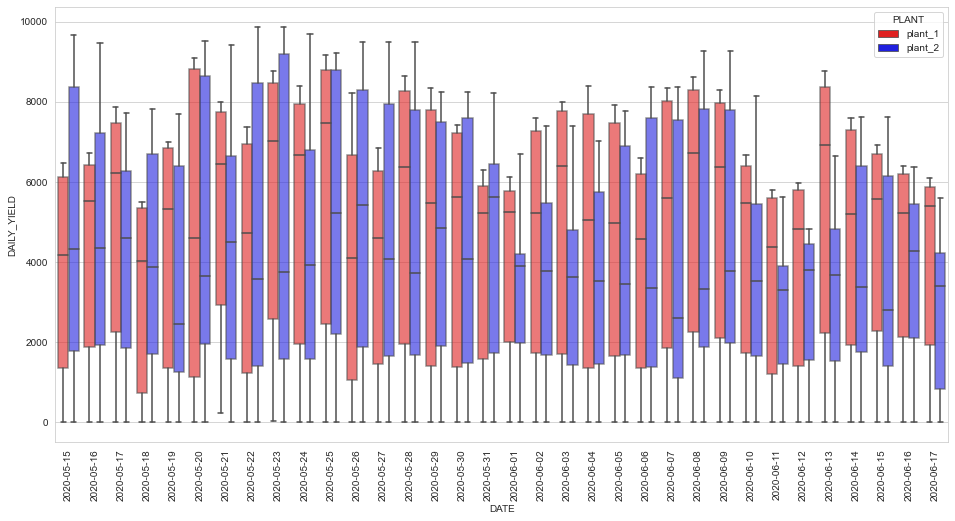

In [11]:
fig, ax = plt.subplots(figsize=(16,8))

spdf_noz = sp_df.loc[(sp_df['DAILY_YIELD'] != 0)]

sns.boxplot(x='DATE', y='DAILY_YIELD', hue='PLANT', palette={'plant_1':'r','plant_2':'b'}, data=spdf_noz, boxprops=dict(alpha=0.6), ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

### Seasonal Decomposition and Stationarity Testing

<Figure size 432x288 with 0 Axes>

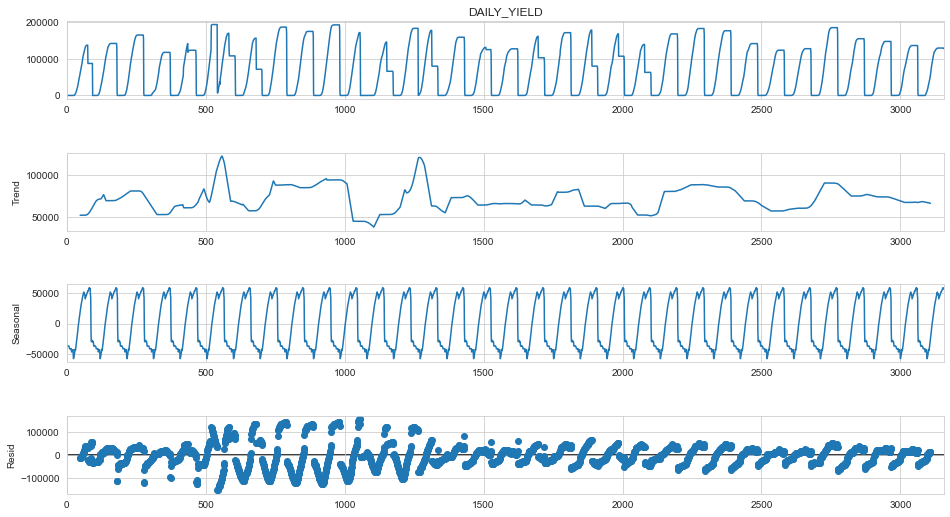

In [12]:
# Generate seasonal decomposition

'''
Borrowed this function definition from https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb
Modified to fit this dataset and more recent pandas syntax updates.
'''

decomp = seasonal_decompose(p1_dt.DAILY_YIELD, period=96)

fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15,8)

<Figure size 432x288 with 0 Axes>

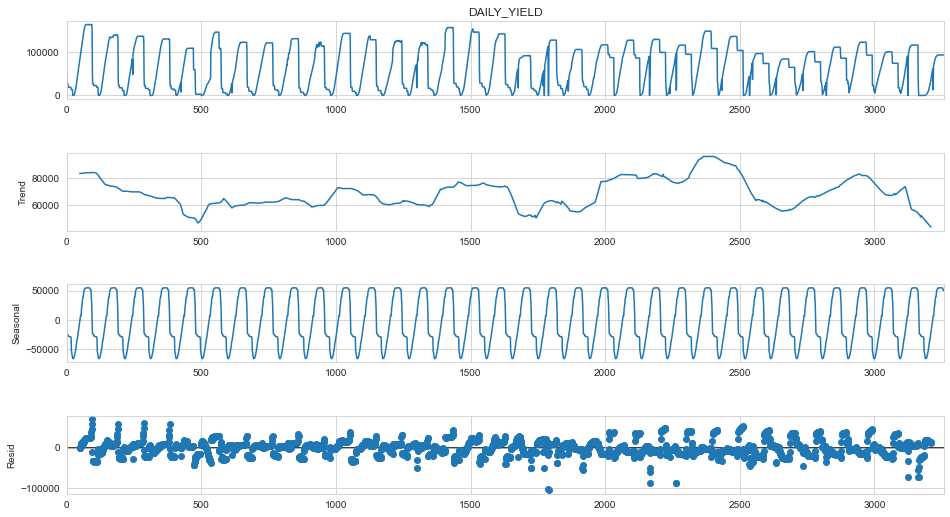

In [13]:
# Generate seasonal decomposition

decomp = seasonal_decompose(p2_dt.DAILY_YIELD, period=96)

fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15,8)

In [14]:
# Create function to test stationarity for different adjustments to time series

'''
Borrowed this function definition from https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb
Modified to fit this dataset and more recent pandas syntax updates.
'''

def test_stationarity(timeseries):
    
    #Determine rolling statistics:
    rolmean = timeseries.rolling(96).mean()
    rolstd = timeseries.rolling(96).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(14,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    #Perform Dickey-Fuller test:
    print('Results of Augmented Dickey-Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for k,v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    print(dfoutput)

In [15]:
def test_stationarity2(timeseries, maxlag):
    #Determine rolling statistics:
    rolmean = timeseries.rolling(96).mean()
    rolstd = timeseries.rolling(96).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(14,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    #Perform Dickey-Fuller test:
    print('Results of Augmented Dickey-Fuller Test')
    dftest = adfuller(timeseries, maxlag=maxlag, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for k,v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    print(dfoutput)

Results of Augmented Dickey-Fuller Test
Test Statistic                -1.416122e+01
p-value                        2.079385e-26
#Lags Used                     2.900000e+01
Number of Observations Used    3.127000e+03
Critical Value (1%)           -3.432443e+00
Critical Value (5%)           -2.862465e+00
Critical Value (10%)          -2.567262e+00
dtype: float64


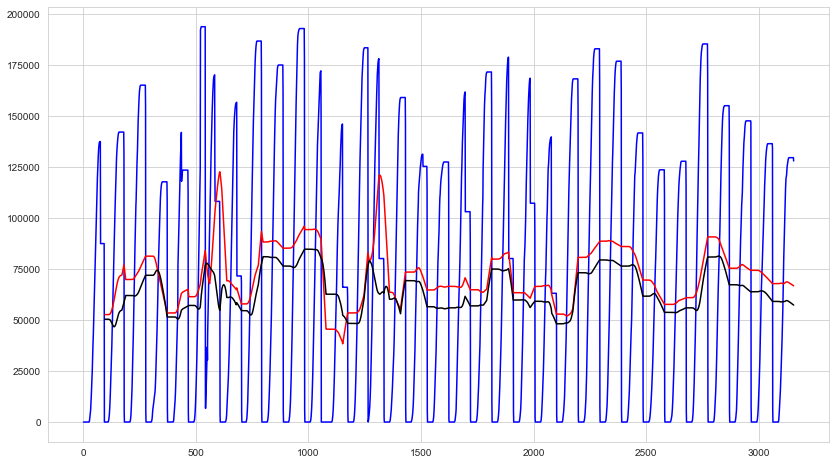

In [16]:
test_stationarity(p1_dt.DAILY_YIELD)

Results of Augmented Dickey-Fuller Test
Test Statistic                -1.561781e+01
p-value                        1.747090e-28
#Lags Used                     2.800000e+01
Number of Observations Used    3.230000e+03
Critical Value (1%)           -3.432376e+00
Critical Value (5%)           -2.862435e+00
Critical Value (10%)          -2.567247e+00
dtype: float64


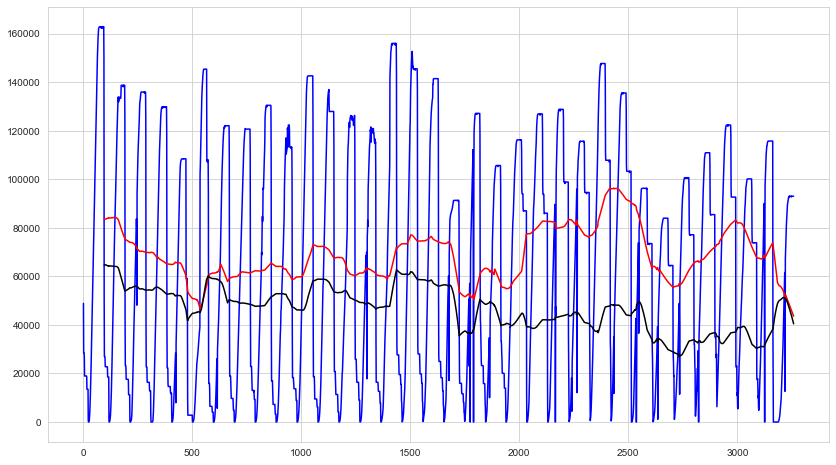

In [17]:
test_stationarity(p2_dt.DAILY_YIELD)

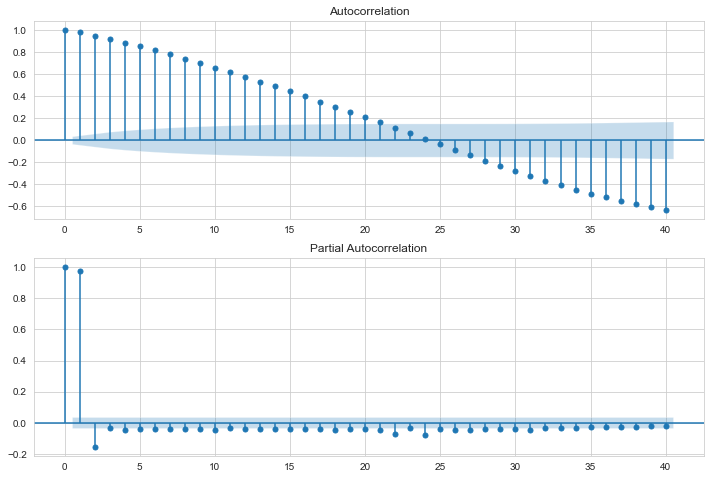

In [18]:
# Plot Autocorrelation and Partial-Autocorrelation functions - Plant1

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(p1_dt.DAILY_YIELD, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(p1_dt.DAILY_YIELD, lags=40, ax=ax2)


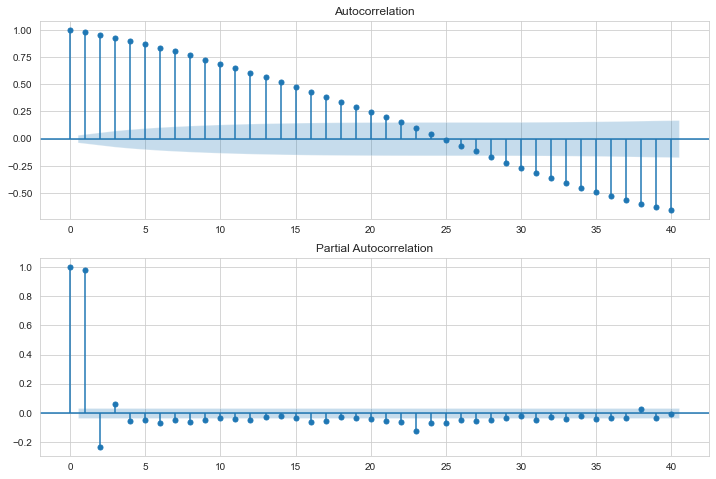

In [19]:
# Plot Autocorrelation and Partial-Autocorrelation functions - Plant2

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(p2_dt.DAILY_YIELD, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(p2_dt.DAILY_YIELD, lags=40, ax=ax2)


Results of Augmented Dickey-Fuller Test
Test Statistic                -7.005676e+00
p-value                        7.132673e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.155000e+03
Critical Value (1%)           -3.432424e+00
Critical Value (5%)           -2.862457e+00
Critical Value (10%)          -2.567258e+00
dtype: float64


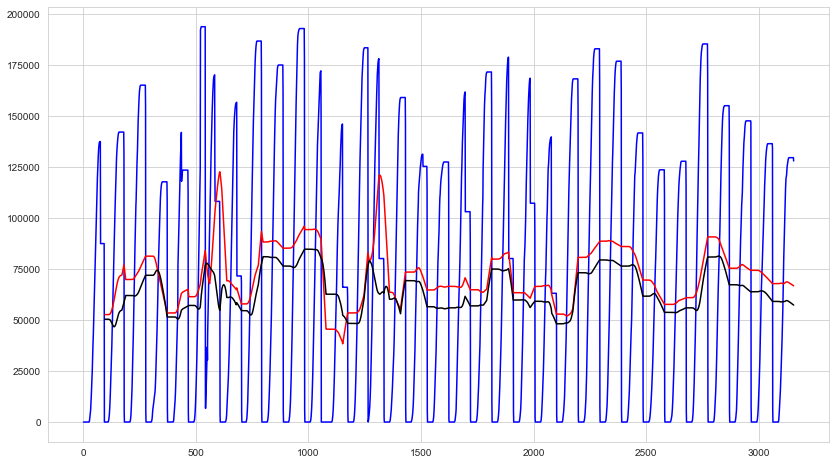

In [20]:
test_stationarity2(p1_dt.DAILY_YIELD, 1)

Results of Augmented Dickey-Fuller Test
Test Statistic                -7.454002e+00
p-value                        5.574100e-11
#Lags Used                     3.000000e+00
Number of Observations Used    3.153000e+03
Critical Value (1%)           -3.432426e+00
Critical Value (5%)           -2.862457e+00
Critical Value (10%)          -2.567258e+00
dtype: float64


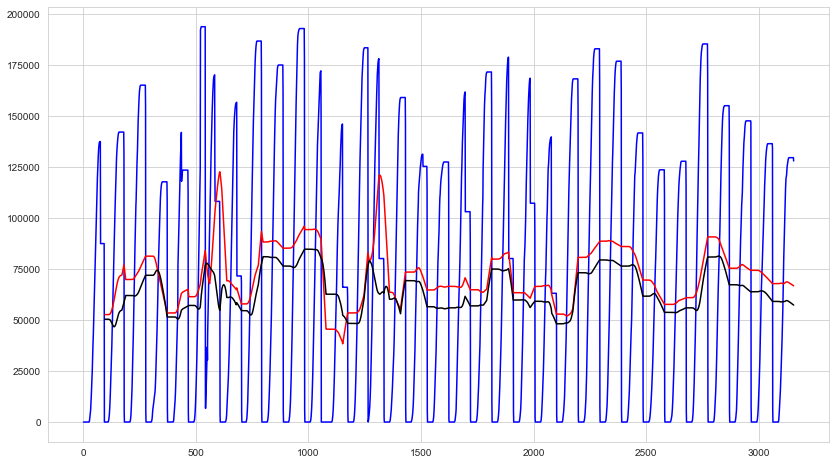

In [21]:
test_stationarity2(p1_dt.DAILY_YIELD, 3)

##### *The optimal number of lags for Plant 1 is 29, and the optimal number of lags for Plant 2 is 28 based on the AIC autolag selection (these numbers are oddly close to the number of days in a typical lunar cycle, which may be irrelevant). These high lag numbers suggest they might not generalize well to new data. By looking at the partial autocorrelation functions, it appears an optimal number of lags for Plant 1 and Plant 2 is 3 for the full data, it will need to be re-considered for each training split.*

### Train/Test Splits

In [22]:
p1_dt.shape, p2_dt.shape

((3157, 10), (3259, 11))

In [23]:
# Set up time series

p1_11=p1_dt.copy()
p1_11=p1_11.groupby('DATE_TIME').sum()
p1_11=p1_11['DAILY_YIELD'].reset_index()
p1_11.set_index('DATE_TIME',inplace=True)

Results of Augmented Dickey-Fuller Test
Test Statistic                -7.005676e+00
p-value                        7.132673e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.155000e+03
Critical Value (1%)           -3.432424e+00
Critical Value (5%)           -2.862457e+00
Critical Value (10%)          -2.567258e+00
dtype: float64


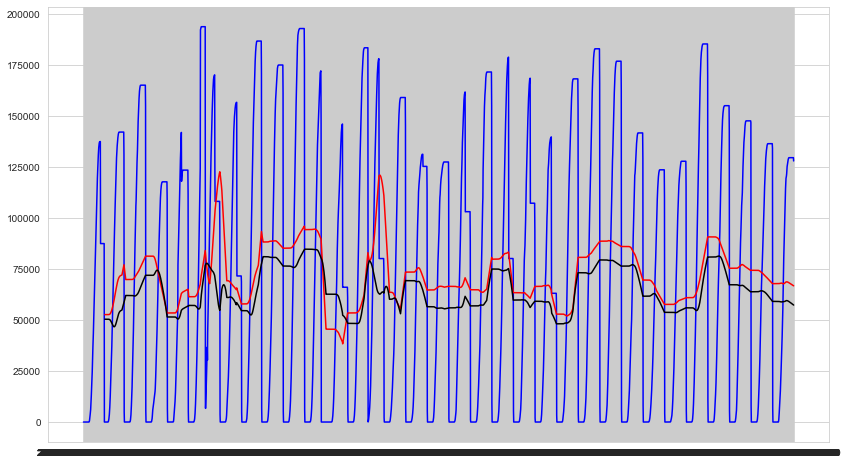

In [24]:
test_stationarity2(p1_11, 1)

#### *The full series has a Test Statistic larger than the critical values and a significantly small p-value, suggesting the null hypothesis can be rejected and the series is stationary.*

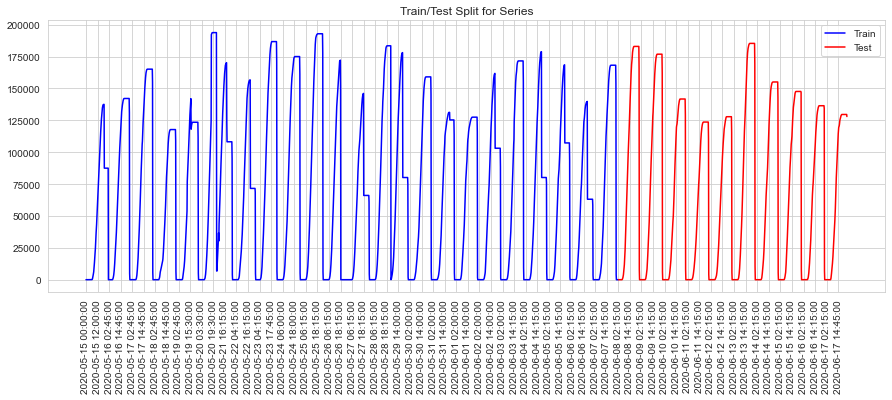

In [25]:
# Train/Test Split for whole time series

train_11 = p1_11[:int(p1_11.shape[0]*0.7)]
test_11 = p1_11[int(p1_11.shape[0]*0.7):]

plt.figure(figsize=(15,5))
plt.plot(train_11,label='Train',color='blue')
plt.plot(test_11,label='Test',color='r')
plt.title('Train/Test Split for Series')
plt.xticks(np.arange(0, 3158, step=48), rotation=90)
plt.legend()
plt.show()

In [26]:
# Splitting time series into quarter period splits

split1=p1_dt.copy()
split1=split1.groupby('DATE_TIME').sum()
split1=split1['DAILY_YIELD'].reset_index()
split1.set_index('DATE_TIME',inplace=True)

p1split_14 = split1[:int(split1.shape[0]*0.25)]
p1split_24 = split1[int(split1.shape[0]*0.25):int(split1.shape[0]*0.5)]
p1split_34 = split1[int(split1.shape[0]*0.5):int(split1.shape[0]*0.75)]
p1split_44 = split1[int(split1.shape[0]*0.75):]

Results of Augmented Dickey-Fuller Test
Test Statistic                  -3.153532
p-value                          0.022837
#Lags Used                       1.000000
Number of Observations Used    787.000000
Critical Value (1%)             -3.438686
Critical Value (5%)             -2.865219
Critical Value (10%)            -2.568729
dtype: float64


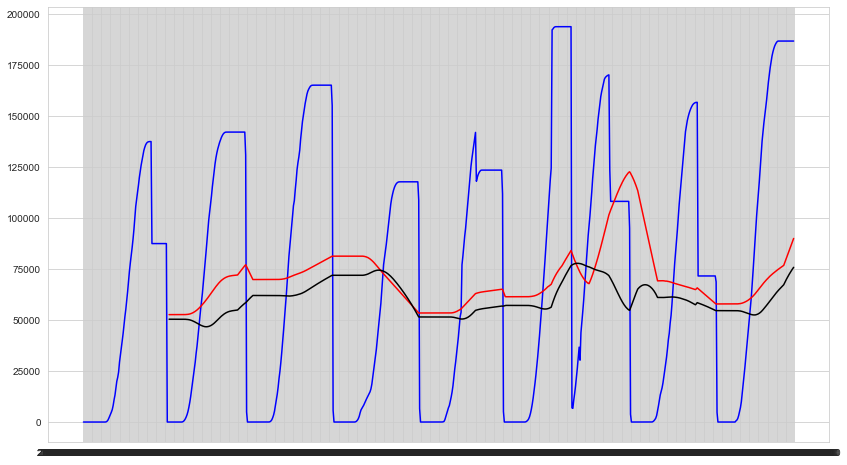

In [27]:
test_stationarity2(p1split_14, 1)

Results of Augmented Dickey-Fuller Test
Test Statistic                  -3.938127
p-value                          0.001772
#Lags Used                       1.000000
Number of Observations Used    787.000000
Critical Value (1%)             -3.438686
Critical Value (5%)             -2.865219
Critical Value (10%)            -2.568729
dtype: float64


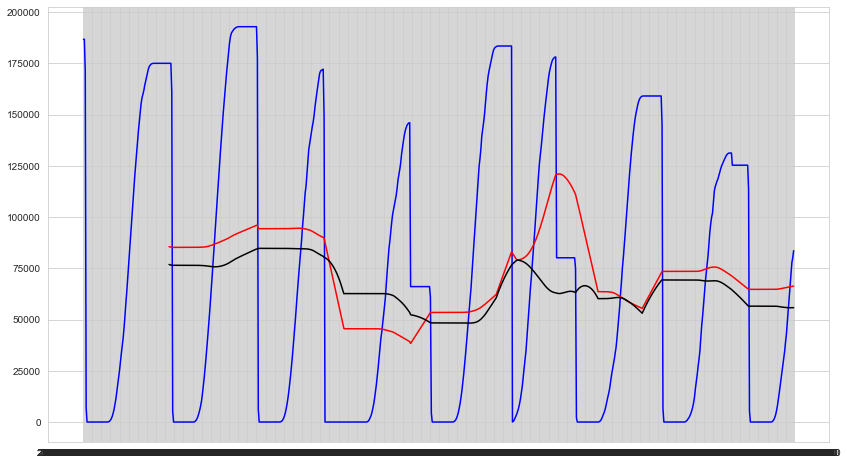

In [28]:
test_stationarity2(p1split_24, 1)

Results of Augmented Dickey-Fuller Test
Test Statistic                  -3.182878
p-value                          0.020997
#Lags Used                       1.000000
Number of Observations Used    787.000000
Critical Value (1%)             -3.438686
Critical Value (5%)             -2.865219
Critical Value (10%)            -2.568729
dtype: float64


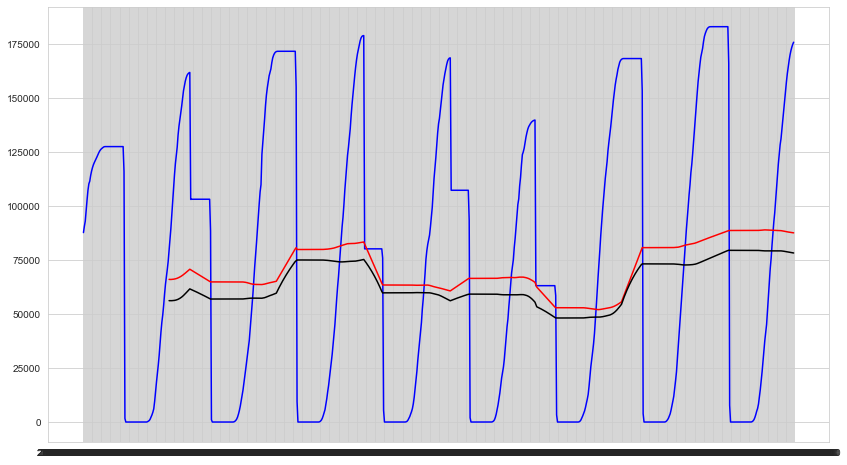

In [29]:
test_stationarity2(p1split_34, 1)

Results of Augmented Dickey-Fuller Test
Test Statistic                  -3.641387
p-value                          0.005017
#Lags Used                       1.000000
Number of Observations Used    788.000000
Critical Value (1%)             -3.438676
Critical Value (5%)             -2.865215
Critical Value (10%)            -2.568727
dtype: float64


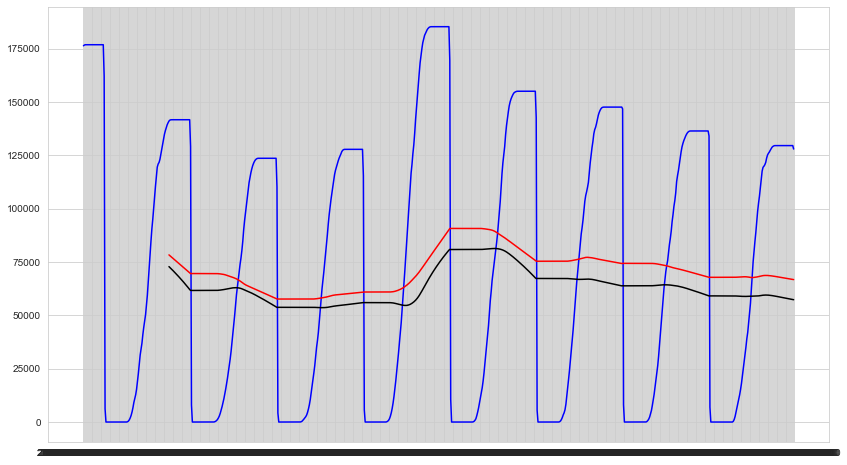

In [30]:
test_stationarity2(p1split_44, 1)

#### *None of the individual quarter-series splits are considered stationary based on their Test Statistic and p-value criteria. Test Statistic is insufficiently large and p-value is insufficiently small, suggesting weak evidence against the null hypothesis (non-stationary).*

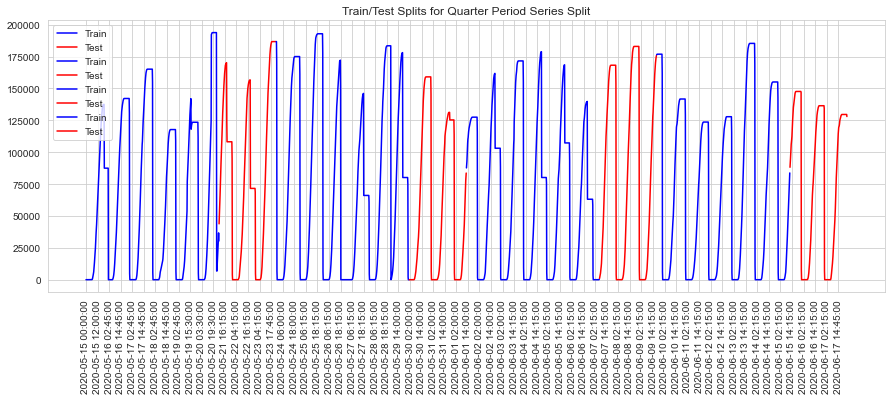

In [31]:
# Train/Test Split for quarter period splits

train_14 = p1split_14[:int(p1split_14.shape[0]*0.7)]
test_14 = p1split_14[int(p1split_14.shape[0]*0.7):]
train_24 = p1split_24[:int(p1split_24.shape[0]*0.7)]
test_24 = p1split_24[int(p1split_24.shape[0]*0.7):]
train_34 = p1split_34[:int(p1split_34.shape[0]*0.7)]
test_34 = p1split_34[int(p1split_34.shape[0]*0.7):]
train_44 = p1split_44[:int(p1split_44.shape[0]*0.7)]
test_44 = p1split_44[int(p1split_44.shape[0]*0.7):]

plt.figure(figsize=(15,5))
plt.plot(train_14,label='Train',color='blue')
plt.plot(test_14,label='Test',color='r')
plt.plot(train_24,label='Train',color='blue')
plt.plot(test_24,label='Test',color='r')
plt.plot(train_34,label='Train',color='blue')
plt.plot(test_34,label='Test',color='r')
plt.plot(train_44,label='Train',color='blue')
plt.plot(test_44,label='Test',color='r')
plt.title('Train/Test Splits for Quarter Period Series Split')
plt.xticks(np.arange(0, 3158, step=48), rotation=90)
plt.legend()
plt.show()

Results of Augmented Dickey-Fuller Test
Test Statistic                  -2.289938
p-value                          0.175234
#Lags Used                       1.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64


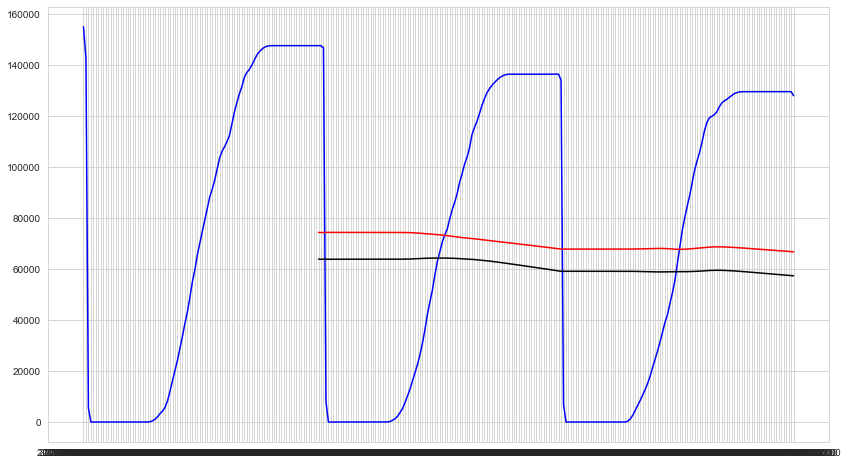

In [32]:
# End of time series for forecasting

pred1=p1_dt.copy()
pred1=pred1.groupby('DATE_TIME').sum()
pred1=pred1['DAILY_YIELD'][-288:].reset_index()
pred1.set_index('DATE_TIME',inplace=True)

test_stationarity2(pred1, 1)

#### *Test Statistic is insufficiently large and p-value is insufficiently small, suggesting weak evidence against the null hypothesis (non-stationary).*

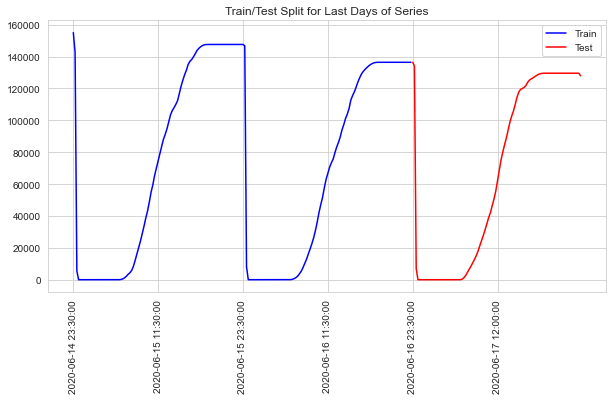

In [33]:
# Train/Test Split for end of time series for forecasting

train_fcst1 = pred1[:192]
test_fcst1 = pred1[-96:]

plt.figure(figsize=(10,5))
plt.plot(train_fcst1,label='Train',color='blue')
plt.plot(test_fcst1,label='Test',color='r')
plt.title('Train/Test Split for Last Days of Series')
plt.xticks(np.arange(0, 288, step=48), rotation=90)
plt.legend()
plt.show()

### Exporting Files for Modeling

In [34]:
# Export Files

sp_df.to_csv('../Data/Proc/sp_df.csv', index=False)
p1_dt.to_csv('../Data/Proc/p1_dt.csv', index=False)
p2_dt.to_csv('../Data/Proc/p2_dt.csv', index=False)

train_11.to_csv('../Data/Proc/train_11.csv')
test_11.to_csv('../Data/Proc/test_11.csv')

train_14.to_csv('../Data/Proc/train_14.csv')
test_14.to_csv('../Data/Proc/test_14.csv')
train_24.to_csv('../Data/Proc/train_24.csv')
test_24.to_csv('../Data/Proc/test_24.csv')
train_34.to_csv('../Data/Proc/train_34.csv')
test_34.to_csv('../Data/Proc/test_34.csv')
train_44.to_csv('../Data/Proc/train_44.csv')
test_44.to_csv('../Data/Proc/test_44.csv')

train_fcst1.to_csv('../Data/Proc/train_fcst1.csv')
test_fcst1.to_csv('../Data/Proc/test_fcst1.csv')